In [1]:
import argparse
import pandas as pd
import numpy as np
import time
import math
import os
import sys
sys.path.append('../..')

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from fedrpdp.datasets.fed_mnist import (
    BaselineModel,
    BaselineLoss,
    metric
)

from fedrpdp.utils.rpdp_utils import (
    get_sample_rate_curve,
    MultiLevels, 
    MixGauss, 
    Pareto,
)

disable_dp = False
device = "cuda:0"
lr = 0.2

project_abspath = os.path.dirname(os.getcwd())
DATA_ROOT = '/data/privacyGroup/liujunxu/datasets/mnist'

train_data = MNIST(DATA_ROOT, train=True, download=True, transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))
test_data = MNIST(DATA_ROOT, train=False, download=True, transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))

train_loader = DataLoader(train_data,
    batch_size=len(train_data), # use all data points
    shuffle=False,
    num_workers=0,
)
test_loader = DataLoader(test_data,
    batch_size=len(test_data),
    shuffle=False,
    num_workers=0,
)

model = BaselineModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0)
criterion = BaselineLoss()

../../fedrpdp/accountants/analysis/rdp.py:358: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


r2 score of the curve fitting. 0.9999605682968435


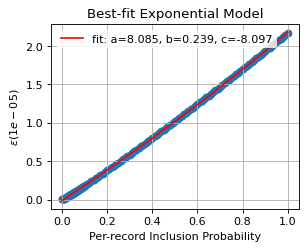

0.48 0.2467
2.53 1.0
{0.24673490960654382, 0.5382453367952886, 1.0}
expected_batch_size: 22821 / 60000


In [2]:
from fedrpdp import PrivacyEngine

# MIN_EPSILON, MAX_EPSILON = 0.5, 1.0
# epsilon_budgets = [0.48] * int(60000 * 0.7) + [1.57] * int(60000 * 0.2) + [5.0] * int(60000 * 0.1)
# noise_multiplier = 20.0
# max_grad_norm = 5.0
# max_epochs = 420
# delta = 1e-5
epsilon_budgets = [0.48] * int(60000 * 0.7) + [1.10] * int(60000 * 0.2) + [2.53] * int(60000 * 0.1)
noise_multiplier = 20.0
max_grad_norm = 5.0
max_epochs = 100
delta = 1e-5


curve_fn = get_sample_rate_curve(
    target_delta = delta,
    noise_multiplier = noise_multiplier,
    num_updates = max_epochs,
    num_rounds = None,
    client_rate = None
)

privacy_engine = PrivacyEngine(accountant="pers_rdp", noise_multiplier=noise_multiplier)
privacy_engine.sample_rate_fn = curve_fn
per_sample_rate = [float(privacy_engine.sample_rate_fn(x)) for x in epsilon_budgets]
print(round(min(epsilon_budgets),4), round(min(per_sample_rate),4))
print(round(max(epsilon_budgets),4), round(max(per_sample_rate),4))
if max(per_sample_rate) == 0.0:
    raise ValueError("Hyper parameter errors! The maximum value of per_sample_rates is zero!")
privacy_engine.sample_rate = per_sample_rate # TODO: make it as an internal func of PrivacyEngine
print(set(privacy_engine.sample_rate))

model, optimizer, train_loader = privacy_engine.make_private_with_personalization(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=noise_multiplier,
    max_grad_norm=max_grad_norm
)

In [3]:
from utils_sgd import train, test

results_all_reps = []

for epoch in range(1, max_epochs + 1):
    start = time.time()
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, metric)
    end = time.time()
    seconds = end - start
    
    test_loss, test_acc = test(model, device, test_loader, criterion, metric)
    
    epsilon_1 = privacy_engine.get_epsilon(0, delta)
    epsilon_2 = privacy_engine.get_epsilon(42000, delta)
    epsilon_3 = privacy_engine.get_epsilon(54000, delta)
    print(f"Epoch: {epoch}")
    print(
        f"Train Loss: {train_loss:.6f} \t Acc: {100*train_acc:.2f}% "
        f"| δ: {delta} "
        f"ε1 = {epsilon_1:.2f}, "
        f"ε2 = {epsilon_2:.2f}, "
        f"ε3 = {epsilon_3:.2f}, "
    )
        
    print("Test  Loss: {:.4f} \t Acc: {:.2f}%\n".format(test_loss, 100*test_acc))
    results_all_reps.append(
        {"test_loss": round(test_loss,4), "test_acc": round(test_acc,4), 
         "seconds": round(seconds,4),
         "e": set(epsilon_budgets), "d": delta, "nm": round(noise_multiplier,2), "norm": max_grad_norm}
    )
    
    results = pd.DataFrame.from_dict(results_all_reps)
    results.to_csv("results_ours.csv", index=False)

2390 / 22688
1042 / 10000
Epoch: 1
Train Loss: 2.306990 	 Acc: 10.53% | δ: 1e-05 ε1 = 0.04, ε2 = 0.09, ε3 = 0.18, 
Test  Loss: 2.2960 	 Acc: 10.42%

2466 / 22821
1595 / 10000
Epoch: 2
Train Loss: 2.295663 	 Acc: 10.81% | δ: 1e-05 ε1 = 0.06, ε2 = 0.14, ε3 = 0.26, 
Test  Loss: 2.2879 	 Acc: 15.95%

3601 / 22849
1793 / 10000
Epoch: 3
Train Loss: 2.287153 	 Acc: 15.76% | δ: 1e-05 ε1 = 0.07, ε2 = 0.17, ε3 = 0.32, 
Test  Loss: 2.2777 	 Acc: 17.93%

4064 / 23071
1984 / 10000
Epoch: 4
Train Loss: 2.278347 	 Acc: 17.62% | δ: 1e-05 ε1 = 0.09, ε2 = 0.20, ε3 = 0.38, 
Test  Loss: 2.2690 	 Acc: 19.84%

4582 / 22730
2007 / 10000
Epoch: 5
Train Loss: 2.268374 	 Acc: 20.16% | δ: 1e-05 ε1 = 0.10, ε2 = 0.22, ε3 = 0.42, 
Test  Loss: 2.2579 	 Acc: 20.07%

4649 / 22917
2020 / 10000
Epoch: 6
Train Loss: 2.258235 	 Acc: 20.29% | δ: 1e-05 ε1 = 0.11, ε2 = 0.24, ε3 = 0.47, 
Test  Loss: 2.2479 	 Acc: 20.20%

4674 / 22898
2027 / 10000
Epoch: 7
Train Loss: 2.247306 	 Acc: 20.41% | δ: 1e-05 ε1 = 0.12, ε2 = 0.26, ε3 

18966 / 22839
8631 / 10000
Epoch: 56
Train Loss: 0.517022 	 Acc: 83.04% | δ: 1e-05 ε1 = 0.35, ε2 = 0.81, ε3 = 1.57, 
Test  Loss: 0.4498 	 Acc: 86.31%

19328 / 22736
8395 / 10000
Epoch: 57
Train Loss: 0.477168 	 Acc: 85.01% | δ: 1e-05 ε1 = 0.35, ε2 = 0.81, ε3 = 1.59, 
Test  Loss: 0.4803 	 Acc: 83.95%

19194 / 22878
8663 / 10000
Epoch: 58
Train Loss: 0.493976 	 Acc: 83.90% | δ: 1e-05 ε1 = 0.35, ε2 = 0.82, ε3 = 1.60, 
Test  Loss: 0.4365 	 Acc: 86.63%

19612 / 22943
8417 / 10000
Epoch: 59
Train Loss: 0.462230 	 Acc: 85.48% | δ: 1e-05 ε1 = 0.36, ε2 = 0.83, ε3 = 1.62, 
Test  Loss: 0.4812 	 Acc: 84.17%

19410 / 23045
8673 / 10000
Epoch: 60
Train Loss: 0.490092 	 Acc: 84.23% | δ: 1e-05 ε1 = 0.36, ε2 = 0.84, ε3 = 1.63, 
Test  Loss: 0.4293 	 Acc: 86.73%

19505 / 22727
8439 / 10000
Epoch: 61
Train Loss: 0.455326 	 Acc: 85.82% | δ: 1e-05 ε1 = 0.36, ε2 = 0.84, ε3 = 1.65, 
Test  Loss: 0.4796 	 Acc: 84.39%

19140 / 22764
8716 / 10000
Epoch: 62
Train Loss: 0.488982 	 Acc: 84.08% | δ: 1e-05 ε1 = 0.37, 